#  Выпускной проект "Телеком"

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
- За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Шаг 1. Исследовательский анализ данных

In [0]:
path = 'datasets/final_provider/'

Импортируем необходимые библиотеки:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Так как дано 4 датасета, удобнее будет работать с ними по одному.

### 1.1. Датасет "contract.csv" — информация о договоре

In [0]:
data_contract = pd.read_csv(path + 'contract.csv')
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Посмотрим на общую информацию:

In [0]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Тип данных у столбцов с датами неверный, столбец TotalCharges также не соответсвует нужному типу данных (float).

In [0]:
print('Количество дубликатов:', data_contract.duplicated().sum())

Количество дубликатов: 0


Добавим столбец c целевым признаком, где 0 - это человек все еще является клиентом компании, а 1 - отказался от услуг:

In [0]:
data_contract['Leaved'] = np.where(data_contract['EndDate']=='No', 0, 1)

In [0]:
print('Из компании ушли', (data_contract['Leaved'].value_counts(normalize=True).round(3) * 100)[1], '% клиентов')

Из компании ушли 26.5 % клиентов


Была обнаружена странность в столбце TotalCharges:

In [0]:
print('Количество строк с пропущенным значением столбца TotalCharges:',
len(data_contract.loc[data_contract['TotalCharges'] == ' ', 'TotalCharges']))

Количество строк с пропущенным значением столбца TotalCharges: 11


Посмотрим на эти строки:

In [0]:
data_contract[data_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Leaved
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Видно, что это новые клиенты. Их договор действует с 01.02.2020, а это и есть дата выгрузки таблицы. Данные пользователи не несут исторической информации, поэтому удалим эти строки:

In [0]:
data_contract.loc[data_contract['TotalCharges'] == ' ', 'TotalCharges'] = np.nan
data_contract = data_contract.dropna(subset=['TotalCharges'])

Переведем тип данных к float:

In [0]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype(float)

Численные данные о клиентах приведены ниже.

Приведем столбцы с датами к нужному типу данных:

In [0]:
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d')

Значения No в столбце EndDate заменим на дату выгрузки таблицы и изменим тип данных.

In [0]:
data_contract['EndDate'] = data_contract['EndDate'].replace('No', '2020-02-01 00:00:00')
data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], format='%Y-%m-%d')

Посмотрим, какие периоды времени охватывают столбцы BeginDate и EndDate. EndDate смотрим только для тех клиентов, кто покинул компанию:

In [0]:
print('BeginDate:  с', data_contract['BeginDate'].min(), 'по', data_contract['BeginDate'].max())
print('EndDate:    с', data_contract[data_contract['Leaved']==1]['EndDate'].min(), 
      'по', data_contract[data_contract['Leaved']==1]['EndDate'].max())

BeginDate:  с 2013-10-01 00:00:00 по 2020-01-01 00:00:00
EndDate:    с 2019-10-01 00:00:00 по 2020-01-01 00:00:00


Добавим столбцец с продолжительностью пребывания клиентами компании:

In [0]:
data_contract['Duration'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.days

In [0]:
data_contract.describe()

,MonthlyCharges,TotalCharges,Leaved,Duration
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.265785,987.538538
std,30.085974,2266.771362,0.441782,747.153663
min,18.250000,18.800000,0.000000,30.000000
25%,35.587500,401.450000,0.000000,275.000000
50%,70.350000,1397.475000,0.000000,883.000000
75%,89.862500,3794.737500,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


Заметим, что среднее время пользования услугами компании составляет три года. Продолжительность с разбивкой по является клиентом/не является рассмотрено чуть ниже чуть ниже.

Добавим столбцы с годом, с месяцем заключения договора. Также добавим столбец с месяцем ухода человека из компании.

In [0]:
data_contract['EndDate_month'] = data_contract['EndDate'].dt.month

Посмотрим количество уходов из компании с разбивкой по месяцам:

In [0]:
data_contract[data_contract['Leaved']==1].groupby('EndDate_month')['customerID'].agg('count')

EndDate_month
1     460
10    458
11    485
12    466
Name: customerID, dtype: int64

Каких либо "всплесков" нет, в среднем уходит одинаковое количество клиентов в месяц.

Гистограмма столбца TotalCharges:

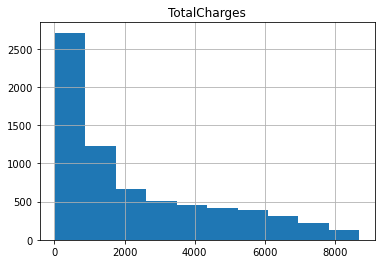

In [0]:
data_contract.hist('TotalCharges')
plt.show()

Гистограмма носит убывающий характер и имеет большой хвост в правой части, что приводит к увеличению среднего и отрыва его от медианы.

Гистограмма столбца MonthlyCharges:

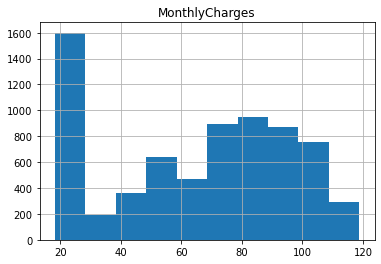

In [0]:
data_contract.hist('MonthlyCharges')
plt.show()

Видно сильный выброс в начале графика. Посмотрим на него до значения 30 поближе:

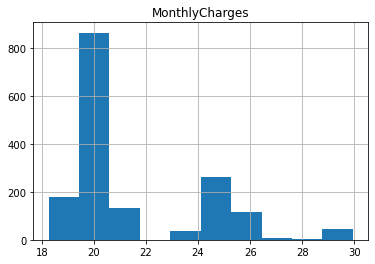

In [0]:
data_contract[data_contract['MonthlyCharges']<30].hist('MonthlyCharges')
plt.show()

Много людей платят в месяц около 20 у.д.

Численные данные остальных столбцов:

Получим срезы таблицы для тех, кто отказался от услуг компании, и для тех, кто остался клиентом:

In [0]:
data_contract_leaved = data_contract[data_contract['Leaved']==1]
data_contract_not_leaved = data_contract[data_contract['Leaved']==0]

Бывшие клиенты:

In [0]:
data_contract_leaved.describe()[['MonthlyCharges', 'TotalCharges', 'Duration']]

,MonthlyCharges,TotalCharges,Duration
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,547.352060
std,24.666053,1890.822994,594.389607
min,18.850000,18.850000,30.000000
25%,56.150000,134.500000,61.000000
50%,79.650000,703.550000,304.000000
75%,94.200000,2331.300000,883.000000
max,118.350000,8684.800000,2191.000000


Нынешние клиенты:

In [0]:
data_contract_not_leaved.describe()[['MonthlyCharges', 'TotalCharges', 'Duration']]

,MonthlyCharges,TotalCharges,Duration
count,5163.000000,5163.000000,5163.000000
mean,61.307408,2555.344141,1146.885532
std,31.094557,2329.456984,732.773458
min,18.250000,18.800000,31.000000
25%,25.100000,577.825000,457.000000
50%,64.450000,1683.600000,1157.000000
75%,88.475000,4264.125000,1857.000000
max,118.750000,8672.450000,2191.000000


- Видно, что уходят из компании разные пользователями: и пробывшие клиентами всего месяц, и 6 лет. Однако в среднем "стаж" на момент ухода от года до двух.
- Клиенты, которые не ушли из компании, давно пользуются ее услугами - в среднем чуть больше 3 лет.
- Нынешние клиенты в среднем в месяц платят чуть меньше, чем бывшие (далее будет видно, что это происходит потому, что они в основном используют годовые и двухгодовые тарифные планы).
- Общая сумма платежей у нынешних клиентов в 1,5-2 раза выше, чем у бывших.

Изучим остальные признакми также с разбивкой по ушел/не ушел:

In [0]:
contract_list = ['Type', 'PaperlessBilling', 'PaymentMethod']

In [0]:
print('Для пользователей, отказавшихся от услуг компании:')
for i in contract_list:
    print()
    print(i + ', %')
    print(data_contract_leaved[f'{i}'].value_counts(normalize=True).round(3) * 100)

Для пользователей, отказавшихся от услуг компании:

Type, %
Month-to-month    88.6
One year           8.9
Two year           2.6
Name: Type, dtype: float64

PaperlessBilling, %
Yes    74.9
No     25.1
Name: PaperlessBilling, dtype: float64

PaymentMethod, %
Electronic check             57.3
Mailed check                 16.5
Bank transfer (automatic)    13.8
Credit card (automatic)      12.4
Name: PaymentMethod, dtype: float64


In [0]:
print('Для пользователей, являющихся клиентами компании:')
for i in contract_list:
    print()
    print(i + ', %')
    print(data_contract_not_leaved[f'{i}'].value_counts(normalize=True).round(3) * 100)

Для пользователей, являющихся клиентами компании:

Type, %
Month-to-month    43.0
Two year          31.7
One year          25.3
Name: Type, dtype: float64

PaperlessBilling, %
Yes    53.6
No     46.4
Name: PaperlessBilling, dtype: float64

PaymentMethod, %
Mailed check                 25.1
Electronic check             25.1
Credit card (automatic)      25.0
Bank transfer (automatic)    24.9
Name: PaymentMethod, dtype: float64


- Практически 89% бывших клиентов пользовались месячными тарифными планами, в то время как 57% нынешних клиентов используют годовые.
- Нынешним пользователям бумажный чек нужен в 46% случаев, тогда как бывшим всего в 25%. Возможно, это связано с большей суммой оплаты за год или два, или из-за оплаты услуг компании работодателем клиента.
- Бывшие клиенты компании использовали электронный чек для оплаты в 57%, остальные методы значительно реже (до 16%). Нынешние же клиенты пользуются всеми методами оплаты в равной степени (по 25%).

Удалим столбцы, не нужные для обучения моделей:

In [0]:
data_contract = data_contract.drop(['BeginDate', 'EndDate', 'EndDate_month'], axis=1)

Посмотрим матрицу корреляции:

In [0]:
corr_matrix = data_contract.corr()
corr_matrix

,MonthlyCharges,TotalCharges,Leaved,Duration
MonthlyCharges,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.651065,1.000000,-0.199484,0.825811
Leaved,0.192858,-0.199484,1.000000,-0.354496
Duration,0.246715,0.825811,-0.354496,1.000000


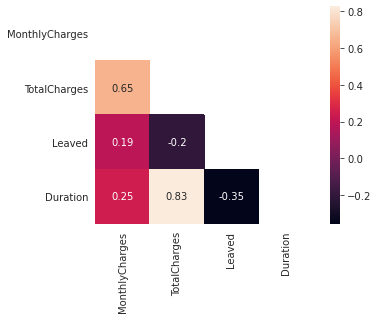

In [0]:
# plt.figure(figsize=(7, 7))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr_matrix, mask=mask, square=True, annot=True) #vmax=.3

Заметна большая положительная корреляция между признаками Duration и TotalCharges, что логично - чем дольше клиент пользуется услугами компании, тем больше сумма его платежей. У целевого признака Leaved сильной корреляции с каком либо другим признаком не наблюдается.

Окончательно таблица приняла следующий вид:

In [0]:
data_contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Leaved,Duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


### 1.2. Датасет "personal.csv" — персональные данные клиента

In [0]:
data_personal = pd.read_csv(path + 'personal.csv')
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [0]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [0]:
print('Количество дубликатов:', data_personal.duplicated().sum())

Количество дубликатов: 0


Пропусков нет, дубликатов нет. Посмотрим на цифры:

In [0]:
data_personal['SeniorCitizen'] = np.where(data_personal['SeniorCitizen']== 0, 'No', 'Yes')

In [0]:
print('Мужчины/женщины, %:')
print(data_personal['gender'].value_counts(normalize=True).round(3)*100)
print()
print('Пенсионеров: ', 
     data_personal['SeniorCitizen'].value_counts().round(3)[1], 'человек, или ',
     data_personal['SeniorCitizen'].value_counts(normalize=True).round(3)[1]*100, '%')
print()
print('В браке, %:')
print(data_personal['Partner'].value_counts(normalize=True).round(3)*100)
print()
print('Есть ли дети, %:')
print(data_personal['Dependents'].value_counts(normalize=True).round(3)*100)

Мужчины/женщины, %:
Male      50.5
Female    49.5
Name: gender, dtype: float64

Пенсионеров:  1142 человек, или  16.2 %

В браке, %:
No     51.7
Yes    48.3
Name: Partner, dtype: float64

Есть ли дети, %:
No     70.0
Yes    30.0
Name: Dependents, dtype: float64


1. Мужчин среди клиентов чуть больше, чем женщин (50,5% против 49,5%), что явно является погрешностью.
2. Среди Клиентов 1142 пенсионера (или 16%).
3. В браке состоит 52% клиентов.
4. Дети есть у 30% клиентов.

### 1.3. Датасет "internet.csv" — информация об интернет-услугах

In [0]:
data_internet = pd.read_csv(path + 'internet.csv')
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [0]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [0]:
print('Количество дубликатов:', data_internet.duplicated().sum())

Количество дубликатов: 0


Пропусков нет, дубликатов нет. Видно, что не все клиенты пользуются интернет услугами (всего клиентов 7043, интернетом пользуются 5517). Посмотрим на цифры:

In [0]:
internet_list = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in internet_list:
    print(i + ', %')
    print(data_internet[f'{i}'].value_counts(normalize=True).round(3)*100)
    print()

InternetService, %
Fiber optic    56.1
DSL            43.9
Name: InternetService, dtype: float64

OnlineSecurity, %
No     63.4
Yes    36.6
Name: OnlineSecurity, dtype: float64

OnlineBackup, %
No     56.0
Yes    44.0
Name: OnlineBackup, dtype: float64

DeviceProtection, %
No     56.1
Yes    43.9
Name: DeviceProtection, dtype: float64

TechSupport, %
No     63.0
Yes    37.0
Name: TechSupport, dtype: float64

StreamingTV, %
No     50.9
Yes    49.1
Name: StreamingTV, dtype: float64

StreamingMovies, %
No     50.5
Yes    49.5
Name: StreamingMovies, dtype: float64



1. В целом, допольнительными услугами (кроме обозначенных далее) не пользуется больше половины клиентов.
2. Самыми полулярными услугами являются стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies). Их используют примерно половина клиентов.

### 1.4. Датасет "phone.csv" — информация об услугах телефонии

In [0]:
data_phone = pd.read_csv(path + 'phone.csv')
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [0]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [0]:
print('Количество дубликатов:', data_phone.duplicated().sum())

Количество дубликатов: 0


In [0]:
print('MultipleLines, %:')
print(data_phone['MultipleLines'].value_counts(normalize=True).round(3)*100)

MultipleLines, %:
No     53.3
Yes    46.7
Name: MultipleLines, dtype: float64


Пропусков нет, дубликатов нет. Услугами телефонии пользуются больше людей, чем интернет услугами. 53% клиентов не используют подключение телефонного аппарата к нескольким линиям одновременно.

## Шаг 2. Объединение таблиц

Во всех таблицах есть общий столбец customerID. По нему и будем объединять. Сначала к данным о контрактах присоеденим таблицу с данными о клиентах. Потом с данными о пользовании услугами интернета.

In [0]:
data = data_contract.merge(data_personal, on = 'customerID', how = 'left')
data = data.merge(data_internet, on = 'customerID', how = 'left')

В таблице образовались пропуски, так как не все клиенты используют интернет. Заполним пропуски маркером "-1".

In [0]:
data = data.fillna('-1')

Присоеденим таблицу с информацией об услугах телефонии:

In [0]:
data = data.merge(data_phone, on = 'customerID', how = 'left')

Опять образовались пропуски, так как не все пользуются услугами телефонии. Заполним маркером "-2".

In [0]:
data = data.fillna('-2')

Удалим столбец customerID, так как он не несет информации для обучения.

In [0]:
data = data.drop(['customerID'], axis=1)

Данные о таблице:

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Leaved              7032 non-null int32
Duration            7032 non-null int64
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
MultipleLines       7032 non-null object
dtypes: float64(2), int32(1), int64(1), object(15)
memory usage: 1.0+ MB


## Шаг 3. Обучение моделей

### 3.0. Подготовка к обучению моделей

Импортируем необхоимые библиотеки:

In [0]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier

Создадим списки котегориальных и количественных признаков:

In [0]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
               'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'MultipleLines']
numeric_features = ['MonthlyCharges', 'TotalCharges', 'Duration']

Функция, которая разбивает датафрейм на обучающую и тестовую выборки, а также стандартизирует количественные признаки:

In [0]:
def train_test_func(data):
    df_train, df_test = train_test_split(data, test_size=0.25, random_state=12345)

    features_train = df_train.drop(['Leaved'], axis=1)
    target_train = df_train['Leaved']
    features_test = df_test.drop(['Leaved'], axis=1)
    target_test = df_test['Leaved']

    scaler = StandardScaler()
    scaler.fit(features_train[numeric_features])
    features_train[numeric_features] = scaler.transform(features_train[numeric_features])
    features_test[numeric_features] = scaler.transform(features_test[numeric_features])

    # Выведем информацию о размерах выборок, чтобы убедиться в правильной разбивке
    print('Количество строк и столбцов в обучающей выборке:', df_train.shape)
    print('Количество строк и столбцов в тестовой выборке:', df_test.shape)
    
    return features_train, target_train, features_test, target_test

Функция, которая выводит на экран результаты кросс-валидации:

In [0]:
def cv_results_print_func(model):
    cv = cross_validate(model, features_train, target_train, cv=5,
                       scoring=['roc_auc', 'accuracy', 'f1', 'precision', 'recall'])
    print()
    print('auc_roc:   ', cv['test_roc_auc'].mean().round(decimals=3))
    print('accuracy:  ', cv['test_accuracy'].mean().round(decimals=3))
    print('f1:        ', cv['test_f1'].mean().round(decimals=3))
    print('precision: ', cv['test_precision'].mean().round(decimals=3))
    print('recall:    ', cv['test_recall'].mean().round(decimals=3))

### 3.1. Обучение различных моделей

#### Логистическая регрессия

Для логистической регрессии будем использовать кодирование OHE.

In [0]:
data_ohe = pd.get_dummies(data, drop_first=True)

features_train, target_train, features_test, target_test = train_test_func(data_ohe)

Количество строк и столбцов в обучающей выборке: (5274, 30)
Количество строк и столбцов в тестовой выборке: (1758, 30)


In [0]:
print('Логистическая регрессия:')
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
cv_results_print_func(model)

Логистическая регрессия:

auc_roc:    0.843
accuracy:   0.749
f1:         0.629
precision:  0.518
recall:     0.8


Значение ROC-AUC = 0.843, от которого можно отталкиваться, получено.

#### LightGBM

Попробуем LightGBM на данных, закодированных с помощью OHE.

In [0]:
print('LightGBM (OHE):')
model = lgb.LGBMClassifier()
cv_results_print_func(model)

LightGBM (OHE):

auc_roc:    0.884
accuracy:   0.838
f1:         0.66
precision:  0.75
recall:     0.59


Теперь закодируем категориальные признаки с помощью OrdinalEncoder и посмотрим на результаты.

In [0]:
data_ordinal = data.copy()
encoder = OrdinalEncoder()
data_ordinal[cat_features] = encoder.fit_transform(data_ordinal[cat_features])

features_train, target_train, features_test, target_test = train_test_func(data_ordinal)

Количество строк и столбцов в обучающей выборке: (5274, 19)
Количество строк и столбцов в тестовой выборке: (1758, 19)


In [0]:
print('LightGBM:')
model = lgb.LGBMClassifier()
cv_results_print_func(model)

LightGBM:

auc_roc:    0.888
accuracy:   0.842
f1:         0.665
precision:  0.761
recall:     0.592


Модель, обученная на признаках, закодированных с помощью OrdinalEncoder дает большее значение ROC-AUC (0.888), чем на признаках, закодированных с помощью OHE (0.884). Обе модели модели показывают скор сильно выше, чем у логистической регрессии.

Посмотрим на график feature importance:

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

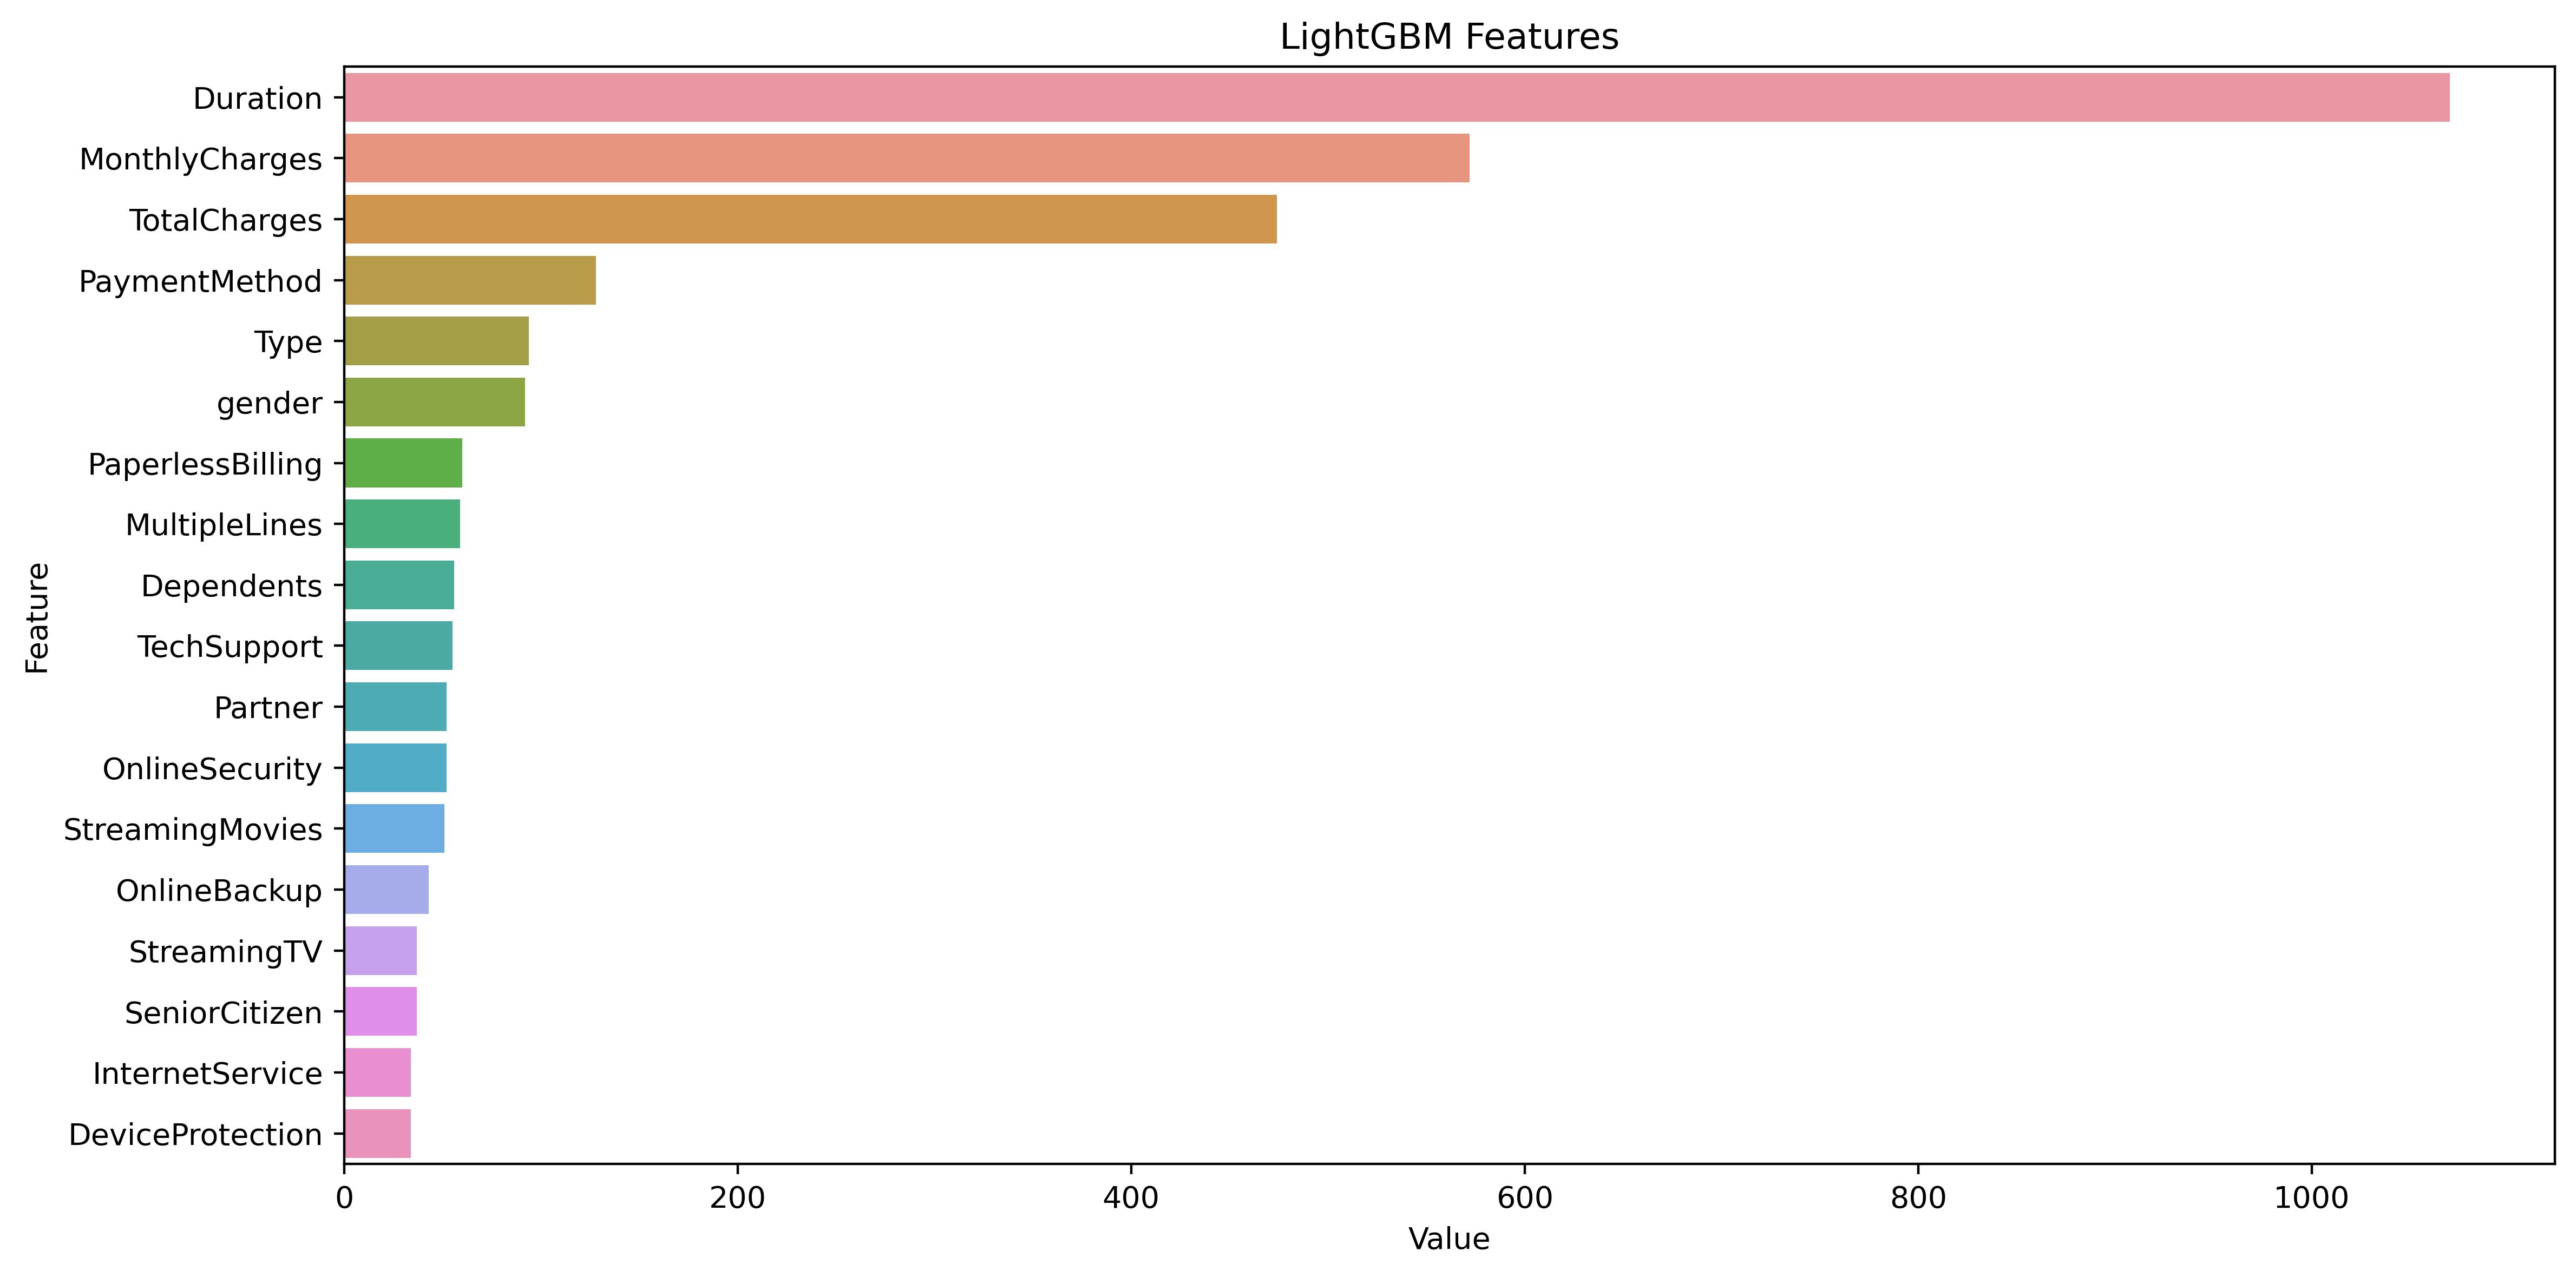

In [0]:
model = lgb.LGBMClassifier()
model.fit(features_train, target_train)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,features_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6), dpi=400)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png', dpi=400)

Видно, что самыми важными фичами являются данные из первой таблицы "contract.csv" — информации о договоре.

#### CatBoost

Обучим CatBoost. Для этой модели отдельно кодировку признаков не нужно проводить.

In [0]:
features_train, target_train, features_test, target_test = train_test_func(data)

Количество строк и столбцов в обучающей выборке: (5274, 19)
Количество строк и столбцов в тестовой выборке: (1758, 19)


In [0]:
print('CatBoost:')
model = CatBoostClassifier(iterations=1000, 
                           cat_features=cat_features, 
                           eval_metric='AUC',
                           random_seed=42,
                           verbose=0)
cv_results_print_func(model)

CatBoost:

auc_roc:    0.886
accuracy:   0.841
f1:         0.654
precision:  0.775
recall:     0.566


Модель показывает себя чуть хуже LightGBM.

##### Итоги подбора моделей:

Метрика\модель  | Константная | LogReg | LightGBM (OHE) | LightGBM | CatBoost |
--------------- | ----------- | ------ | -------------- | -------- | -------- |
ROC-AUC         | 0.5         | 0.843  | 0.884          | 0.888    | 0.886    |
Accuracy        | 0.734       | 0.749  | 0.838          | 0.842    | 0.841    |
F1              | -           | 0.629  | 0.660          | 0.665    | 0.654    |
Precision       | -           | 0.518  | 0.750          | 0.761    | 0.775    |
Recall          | -           | 0.800  | 0.590          | 0.592    | 0.566    |


Модель LightGBM, обученная на признаках, закодированных с помощью OrdinalEncoder дала наибольшее значение ROC-AUC (0.888) на кросс-валидации среди испытанных моделей.

### 3.2. Тестирование выбранной модели

In [0]:
features_train, target_train, features_test, target_test = train_test_func(data_ordinal)

Количество строк и столбцов в обучающей выборке: (5274, 19)
Количество строк и столбцов в тестовой выборке: (1758, 19)


In [0]:
model = lgb.LGBMClassifier()
model.fit(features_train, target_train)
predicted = model.predict(features_test)

accuracy = accuracy_score(target_test, predicted)
f1 = f1_score(target_test, predicted)
precision = precision_score(target_test, predicted)
recall = recall_score(target_test, predicted)

probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one)

print('LightGBM (test)')
print()
print('auc_roc:   ', auc_roc.round(decimals=3))
print('accuracy:  ', accuracy.round(decimals=3))
print('f1_score:  ', f1.round(decimals=3))
print('precision: ', precision.round(decimals=3))
print('recall:    ', recall.round(decimals=3))

LightGBM (test)

auc_roc:    0.9
accuracy:   0.852
f1_score:   0.685
precision:  0.78
recall:     0.611


Модель показала отличные результаты на тестовой выборке: ROC-AUC = 0.9 и accuracy = 0.852.

Модель удовлетворяет условию и поставленной задаче.

## Шаг 4. Отчет по проделанной работе

Изначально план выглядел так:
1. Провести препроцессинг. Исследовать данные, добавить новые данные.
2. Объеденить таблицы в одну большую, подготовить для использования в моделях, удалить лишние столбцы.
3. Для решения задачи классификации по столбцу Leaved исследовать различные модели машинного обучения.
4. Выбрать оптимальную модель.
5. Оформить отчет.

План был составлен общим и все пукнты были так или иначе выполнены. В исследовательском анализе и препроцессинге изначально предпологалась добавление нескольких новых признаков. Однако потом было решено оставить только один - продолжительность контракта, так как другие (год и месяц начала контракта и др.) плохо подходят для объяснения их бизнесу. Также изначально были мысли попробовать больше моделей, но потом посмотрев, что LightGBM работает не сильно дольше (на локальной машине) логистической регрессии и дает ощутимо больший скор, от остальных моделей было решено отказаться. CatBoost давал тоже большой скор, но работал сильно дольше.

Главной трудностью стал выбор фич, которые оставить или сгенерить по первой таблице. Изначально я оставлял как продолжительность контракта, так и год и месяц его начала. Это приводило к лику в данных, и значение метрики ROC-AUC было в районе 0,99 на кроссвалидации. После этого дата начала контракта была удалена из признаков, и получена окончательная таблица, на которой модели показывают реальные показатели метрики.

Первым ключевым шагом было определение целевого признака, так как явно в представленных таблицах его не было. Следующим - получение столбца с продолжительностью контракта. Следующие шаги стандартны для подобного рода задач.

Итоговой моделью была выбрана LightGBM, обученная на признаках, закодированных с помощью OrdinalEncoder. Она показала наибольшее значение как метрики ROC-AUC (0.888), так и метрики Accuracy (0.842), на кросс-валидации среди испытанных моделей. На отложенной тестовой выборке она дала даже лучшие показатели: ROC-AUC = 0.9, Accuracy = 0.852.